# Dataloader de BERTMHC

En este script, se detalla el dataloader para preparar el training set. EL training set de ejemplo esta en el archivo train_old.csv
De dicho archivo, se utiliza la columna 'mhc' y 'peptide' concatenadas como input y el target esta compuesto por las columnas 'label' y 'masslabel'. Tambien se utiliza un la función collate_fn de pytorch para asegurar el mismo tamaño de los inputs.



In [1]:

from typing import Union, List, Tuple, Sequence, Dict, Any, Optional, Collection, Mapping
from pathlib import Path
from tape.tokenizers import TAPETokenizer
from tape.datasets import pad_sequences as tape_pad
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
import re

from torch.utils.data import DataLoader
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from bertmhc import BERTMHC, BERTMHC_CNN
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils_model import EarlyStopping
from utils_model import train, evaluate

class CSVDataset(Dataset):
    def __init__(self,
                 data_file: Union[str, Path, pd.DataFrame],
                 max_pep_len=60,
                 train: bool = True):
        if isinstance(data_file, pd.DataFrame):
            data = data_file
        else:
            data = pd.read_csv(data_file)
        mhc = data['mhc']
        self.mhc = mhc.values
        peptide = data['peptide']
        peptide = peptide.apply(lambda x: x[:max_pep_len])
        self.peptide = peptide.values
        if not train:
            data['label'] = np.nan
            data['masslabel'] = np.nan
        if 'masslabel' not in data and 'label' not in data:
            raise ValueError("missing label.")
        if 'masslabel' not in data:
            data['masslabel'] = np.nan
        if 'label' not in data:
            data['label'] = np.nan

        ###########################################################################################################
        ##### el target esta compuesto por el label(float) y masslabel(int) #######################################
        self.targets = np.stack([data['label'], data['masslabel']], axis=1)
        self.data = data        

    def __len__(self) -> int:
        return len(self.mhc)

    def __getitem__(self, index: int):
        ###########################################################################################################
        ##### aqui concatena el MHC con el peptido para que todo eso sea el input #################################
        seq = self.mhc[index] + self.peptide[index]
        
        # aqui hacemos padding y reemplazamos algunos aminoacidos
        #seq = seq + 'X' * (58 - len(seq)) 
        #seq = re.sub(r"[UZOBJ]", "X", seq).upper()
        
        return {
            "id": str(index),
            "primary": seq,
            "protein_length": len(seq),
            "targets": self.targets[index]}
    


class BertDataset(Dataset):
    ''' Load data for pretrained Bert model, implemented in TAPE
    '''

    def __init__(self,
                 input_file,
                 tokenizer: Union[str, TAPETokenizer] = 'iupac',
                 max_pep_len=30,
                 train: bool = True):
        if isinstance(tokenizer, str):
            tokenizer = TAPETokenizer(vocab=tokenizer)
        self.tokenizer = tokenizer
        self.data = CSVDataset(input_file,
                               max_pep_len=max_pep_len,
                               train=train)        

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        item = self.data[index]
        
        token_ids = self.tokenizer.encode(item['primary'])
        input_mask = np.ones_like(token_ids)
        ret = {'input_ids': token_ids,
               'input_mask': input_mask,
               'targets': item['targets']}
        
        return ret

    def collate_fn(self, batch) -> Dict[str, torch.Tensor]:
        elem = batch[0]
        batch = {key: [d[key] for d in batch] for key in elem}
        input_ids = torch.from_numpy(tape_pad(batch['input_ids'], 0))
        input_mask = torch.from_numpy(tape_pad(batch['input_mask'], 0))
        tmp = np.array(batch['targets'])
        #targets = torch.tensor(batch['targets'], dtype=torch.float32)
        targets = torch.tensor(tmp, dtype=torch.float32)
        ret = {'input_ids': input_ids,
               'input_mask': input_mask,
               'targets': targets}
        
        return ret
    
# dataset
trainset = BertDataset('../../dataset/netMHCIIpan3.2/train_mini.csv', max_pep_len=24)
valset = BertDataset('../../dataset/netMHCIIpan3.2/eval_mini.csv', max_pep_len=24)
first_sample = trainset[0] 
#print(first_sample['input_ids']) # indices del one-hot encoding
#print(first_sample['input_mask'])
#print(first_sample['targets']) 
print(first_sample)
print(first_sample['input_ids'].shape)

logging.basicConfig(format='%(name)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

train_data = DataLoader(        trainset,
                                batch_size=32,
                                shuffle=True,
                                num_workers=16,
                                pin_memory=True,
                                collate_fn=trainset.collate_fn)

val_data = DataLoader(        valset,
                              batch_size=64,
                              num_workers=16,
                              pin_memory=True,
                              collate_fn=valset.collate_fn)

logger.info("Training on {0} samples, eval on {1}".format(len(trainset), len(valset)))


/home/vicente/anaconda3/envs/torch11/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
__main__ - Training on 107424 samples, eval on 13428


{'input_ids': array([ 2, 20,  9, 10, 10, 13,  5, 22, 11,  5,  5, 25,  8,  5, 13, 16,  9,
       22, 22, 10,  8, 28, 10,  8, 13,  8,  9,  5, 23, 28, 12, 25, 25, 10,
       23, 23, 13, 19, 15, 25,  5, 15, 23, 15, 23, 22, 28, 15, 11, 15, 14,
        3]), 'input_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1]), 'targets': array([0.698876, 1.      ])}
(52,)


Trainset

# BERTMHC

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

print("\nCargamos los pesos de TAPE\n\n")
model = BERTMHC.from_pretrained('bert-base')

for p in model.bert.parameters():
    p.requires_grad = True

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
print(model)

Device cuda

Cargamos los pesos de TAPE




tape.models.modeling_utils - loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /home/vicente/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
tape.models.modeling_utils - Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_size": 768,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 30
}

tape.models.modeling_utils - loading weights file https://s3.a

BERTMHC(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1, i

Parametros de BERTMHC

TAPE tiene 92356612 parametros <br>
ProtTrans (prot_bert_bfd) tiene 419933186 (4x larger)

In [8]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("params:", pytorch_total_params)

#from torchvision import models
#from torchsummary import summary
#summary(model, (60, 768))

params: 92356612


# BERTMHC CNN

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

print("\nCargamos los pesos de TAPE\n\n")
model = BERTMHC_CNN.from_pretrained('bert-base')

for p in model.bert.parameters():
    p.requires_grad = True

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

print(model)

Device cuda

Cargamos los pesos de TAPE




tape.models.modeling_utils - loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /home/vicente/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
tape.models.modeling_utils - Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_size": 768,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 30
}

tape.models.modeling_utils - loading weights file https://s3.a

BERTMHC_CNN(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.

# BERTMHC Linear

In [1]:
from bertmhc import BERTMHC_LINEAR, BERTMHC

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

#model = BERTMHC_LINEAR.from_pretrained('bert-base')
model = BERTMHC_LINEAR.from_pretrained('bert-base')

for p in model.bert.parameters():
    p.requires_grad = True

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

print(model)

/home/vicente/anaconda3/envs/torch11/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

KeyboardInterrupt



# BERTMHC RNN ATTENTION

In [2]:
from bertmhc import BERTMHC_RNN_ATT

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

#model = BERTMHC_LINEAR.from_pretrained('bert-base')
model = BERTMHC_RNN_ATT.from_pretrained('bert-base')

for p in model.bert.parameters():
    p.requires_grad = True

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

print(model)

Device cuda


tape.models.modeling_utils - loading configuration file https://s3.amazonaws.com/songlabdata/proteindata/pytorch-models/bert-base-config.json from cache at /home/vicente/.cache/torch/protein_models/fbb05edff0ffa844a729a04850272a1f8973bc002526f6615ad113a5f5aacd36.05edb4ed225e1907a3878f9d68b275d79e025b667555aa94a086e27cb5c591e0
tape.models.modeling_utils - Model config {
  "attention_probs_dropout_prob": 0.1,
  "base_model": "transformer",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 8192,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_size": 768,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 30
}

tape.models.modeling_utils - loading weights file https://s3.a

BERTMHC_RNN_ATT(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(

# Train

In [3]:
epochs = 10
lr = 0.15
w_pos = 1.0 # mass positive weight
save = "TRAIN_x_bertmhc_model.pt"
alpha = 0.0 # alpha weight on mass loss, affinity loss weight with 1-alpha
patience = 5 # Earlystopping patience
metric = 'val_auc' # validation metric, default auc

aff_criterion = nn.BCEWithLogitsLoss()
w_pos = torch.tensor([w_pos]).to(device)
mass_criterion = nn.BCEWithLogitsLoss(pos_weight=w_pos, reduction='none')

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=2, min_lr=1e-4, factor=0.1)

early_stopping = EarlyStopping(patience=patience, verbose=True, saveto=save)

for epoch in range(epochs):
    print("Training epoch {}".format(epoch))
    train_metrics = train(model, optimizer, train_data, device, aff_criterion, mass_criterion, alpha, scheduler)
    eval_metrics = evaluate(model, val_data, device, aff_criterion, mass_criterion, alpha)
    eval_metrics['train_loss'] = train_metrics
    logs = eval_metrics

    scheduler.step(logs.get(metric))
    logging.info('Sample dict log: %s' % logs)

    # callbacks
    early_stopping(-logs.get(metric), model, optimizer)
    if early_stopping.early_stop or logs.get(metric) <= 0:
        print("Early stopping")
        break

Training epoch 0


  0%|          | 0/3357 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

# Evaluate dimensiones de los modelos

In [12]:
import torch.nn.functional as F

# con una CNN 1d
n = nn.Conv1d(60, 128, kernel_size=3)

input = torch.randn(32, 60, 768) # embed de tape con batch size 32 [batch_size, dimx, dimy]
output = n(input)
#print(output)

# con una CNN 2d
n1 = nn.Conv2d(1, 6, kernel_size=5)
n2 = nn.MaxPool2d(2, 2)  
n3 = conv2 = nn.Conv2d(6, 16, 5) 

n4 = nn.Linear(16*12*189, 10000) 
n6 = nn.Linear(10000, 500)
n7 = nn.Softmax()    

input = torch.randn(32, 60, 768) # input desde tape model con 32 de batch size
input = input.view(32, 1, 60, 768)

#input = torch.randn(32, 1, 60, 768)
x = F.relu(n1(input))           # [32, 1, 60, 768] -> [32, 6, 56, 764]
print(x.shape)
x = n2(x)                       # [32, 6, 56, 764] -> [32, 6, 28, 382]
print(x.shape)
x = F.relu(n3(x))               # [32, 6, 28, 382] -> [32, 16, 24, 378]
print(x.shape)
x = n2(x)                       # [32, 16, 24, 378] -> [32, 16, 12, 189]
print(x.shape)

x = x.view(-1, 16*12*189) 
print(x.shape)

x = F.relu(n4(x))
print(x.shape)
output = F.softmax(n6(x))
print(output.shape)
#outputs = n7(x) 
#print(x.shape)
print(output)

torch.Size([32, 6, 56, 764])
torch.Size([32, 6, 28, 382])
torch.Size([32, 16, 24, 378])
torch.Size([32, 16, 12, 189])
torch.Size([32, 36288])
torch.Size([32, 10000])
torch.Size([32, 500])
tensor([[0.0018, 0.0019, 0.0023,  ..., 0.0021, 0.0021, 0.0020],
        [0.0019, 0.0020, 0.0023,  ..., 0.0021, 0.0021, 0.0021],
        [0.0018, 0.0020, 0.0023,  ..., 0.0021, 0.0022, 0.0020],
        ...,
        [0.0019, 0.0020, 0.0023,  ..., 0.0021, 0.0021, 0.0021],
        [0.0019, 0.0020, 0.0023,  ..., 0.0021, 0.0021, 0.0021],
        [0.0019, 0.0019, 0.0022,  ..., 0.0021, 0.0020, 0.0021]],
       grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_23905/2800599566.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(n6(x))


: 

In [10]:
import torch.nn.functional as F
import torch
import torch.nn as nn

dropout     = nn.Dropout(0.2)
linear      = nn.Linear(768, 1)
sigmoid     = nn.Sigmoid()    

input = torch.randn(32, 1, 768) 

out = dropout(input)   
out = linear(out) 
out = sigmoid(out)         

print(out.shape)
print(out)

from tape.models.modeling_utils import SimpleMLP
logits = self.classify(average, targets)

torch.Size([32, 1, 1])
tensor([[[0.5482]],

        [[0.4293]],

        [[0.5503]],

        [[0.4340]],

        [[0.6277]],

        [[0.5838]],

        [[0.4624]],

        [[0.6540]],

        [[0.6292]],

        [[0.8801]],

        [[0.1949]],

        [[0.4478]],

        [[0.7024]],

        [[0.7735]],

        [[0.2155]],

        [[0.3104]],

        [[0.6967]],

        [[0.4506]],

        [[0.4824]],

        [[0.4654]],

        [[0.4646]],

        [[0.4440]],

        [[0.4283]],

        [[0.4069]],

        [[0.5271]],

        [[0.4635]],

        [[0.7084]],

        [[0.3120]],

        [[0.4717]],

        [[0.5794]],

        [[0.4974]],

        [[0.3781]]], grad_fn=<SigmoidBackward0>)


# Testing

In [4]:
import sys
from utils_model import EarlyStopping, MAData
from tape import ProteinBertConfig
from dataloader import BertDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
from bertmhc import BERTMHC
from torch.optim.lr_scheduler import ReduceLROnPlateau
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from utils_model import train, evaluate

def predict(data, model_path, output_path):
    inp = data
    config = ProteinBertConfig.from_pretrained('bert-base')
    model = BERTMHC(config)
    weights = torch.load(model_path)
    
    if list(weights.keys())[0].startswith('module.'):
        weights = {k[7:]: v for k, v in weights.items() if k.startswith('module.')}
    model.load_state_dict(weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    valset = BertDataset(inp,
                         max_pep_len=24,
                         train=False)
    val_data = DataLoader(valset,
                          batch_size=16,
                          num_workers=16,
                          pin_memory=True,
                          collate_fn=valset.collate_fn)
    pred = []
    for batch in tqdm(val_data):
        batch = {name: tensor.to(device)
                 for name, tensor in batch.items()}
        logits, _ = model(**batch)
        pred.append(torch.sigmoid(logits).cpu().detach().numpy())
    dt = pd.read_csv(inp)
    pred = np.concatenate(pred)
    
    '''if args.task == 'binding':
        dt['bertmhc_pred'] = pred[:,0]
    else:
        dt['bertmhc_pred'] = pred[:,1]'''
    
    dt['bertmhc_pred'] = pred[:,0]
    dt.to_csv(output_path, index=None)
    return dt

Predict del modelo TRAIN_3 de la forma igual a BERTMHC

In [11]:
dt_train_3 = predict(    data        =   "../../dataset/netMHCIIpan3.2/test_mini.csv", 
            model_path  =   "TRAIN_3_bertmhc_model.pt", 
            output_path =   "train_3_results.csv")

100%|██████████| 840/840 [00:18<00:00, 45.40it/s]


In [34]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

dt_train_3['pred'] = dt_train_3.apply(lambda row: (1 if row['bertmhc_pred'] > 0.426 else 0), axis=1)    # 0.807952937672202
#dt_train_3['pred'] = dt_train_3.apply(lambda row: (1 if row['bertmhc_pred'] > 0.5 else 0), axis=1)     # 0.7962618214312309

y_true_3 = dt_train_3['masslabel'].to_numpy()
y_pred_3 = dt_train_3['pred'].to_numpy()
acc = accuracy_score(y_true_3, y_pred_3)
precision, recall, fscore, _ =  precision_recall_fscore_support(y_true_3, y_pred_3, average='macro')
result_3 = {"acc":acc, "precision":precision, "recall":recall, "fscore":fscore }
print(result_3)
confusion_matrix(y_true_3, y_pred_3)
#print(accuracy_score(y_true, y_pred, normalize=False))

{'acc': 0.8066125549184601, 'precision': 0.8008178687638494, 'recall': 0.8001206157435652, 'fscore': 0.8004603694779975}


array([[6595, 1277],
       [1320, 4237]])

Predict del modelo TRAIN_4 de la forma igual a BERTMHC pero con padding

In [13]:
# tenemos q entrear una vez mas train_4
dt_train_4 = predict(    data        =   "../../dataset/netMHCIIpan3.2/test_mini.csv", 
            model_path  =   "TRAIN_4_bertmhc_model.pt", 
            output_path =   "train_4_results.csv")

100%|██████████| 840/840 [00:18<00:00, 45.71it/s]


In [35]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

dt_train_4['pred'] = dt_train_4.apply(lambda row: (1 if row['bertmhc_pred'] > 0.426 else 0), axis=1)    # 0.7375083773922109
#dt_train_4['pred'] = dt_train_4.apply(lambda row: (1 if row['bertmhc_pred'] > 0.5 else 0), axis=1)       # 0.7178494303373296

y_true_4 = dt_train_4['masslabel'].to_numpy()
y_pred_4 = dt_train_4['pred'].to_numpy()
acc = accuracy_score(y_true_4, y_pred_4)
precision, recall, fscore, _ =  precision_recall_fscore_support(y_true_4, y_pred_4, average='macro')
result_4 = {"acc":acc, "precision":precision, "recall":recall, "fscore":fscore }
print(result_4)
confusion_matrix(y_true_4, y_pred_4)

{'acc': 0.7375083773922109, 'precision': 0.7352630171197421, 'recall': 0.7147436407387737, 'fscore': 0.7192116524243642}


array([[6666, 1206],
       [2319, 3238]])

Comparison

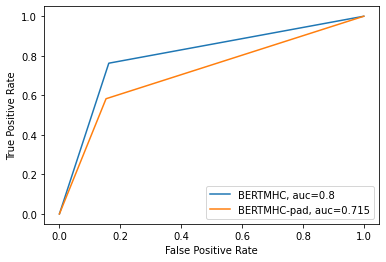

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_3, tpr_3, _ = metrics.roc_curve(y_true_3,  y_pred_3)
auc_3 = metrics.roc_auc_score(y_true_3, y_pred_3)

fpr_4, tpr_4, _ = metrics.roc_curve(y_true_4,  y_pred_4)
auc_4 = metrics.roc_auc_score(y_true_4, y_pred_4)

#create ROC curve
plt.plot(fpr_3,tpr_3, label="BERTMHC, auc="+str(round(auc_3,3)))
plt.plot(fpr_4,tpr_4, label="BERTMHC-pad, auc="+str(round(auc_4, 3)))
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('roc_comparison.png', dpi=300)

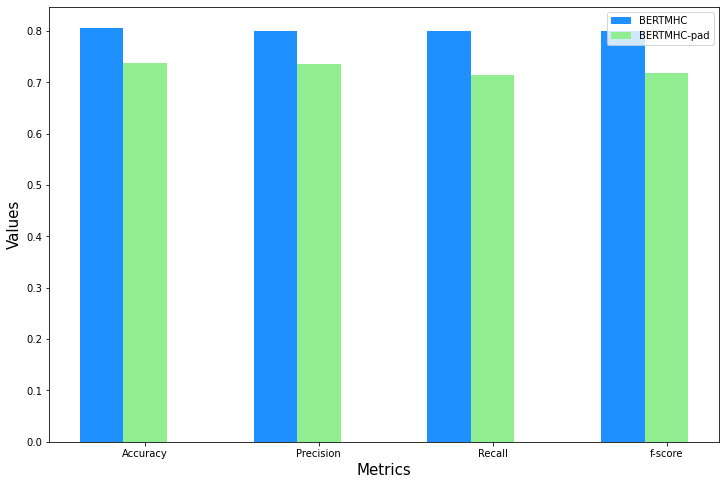

In [49]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = list(result_3.values())
ECE = list(result_4.values())
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, IT, color ='dodgerblue', width = barWidth, label ='BERTMHC')
plt.bar(br2, ECE, color ='lightgreen', width = barWidth, label ='BERTMHC-pad')
 
# Adding Xticks
plt.xlabel('Metrics',  fontsize = 15)
plt.ylabel('Values', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        ['Accuracy', 'Precision', 'Recall', 'f-score'])
 
plt.legend()
#plt.show()
plt.savefig('metrics_comparison.png', dpi=300)